<a href="https://colab.research.google.com/github/varshini03/signature-recognition-system/blob/main/ML_PROJECT_SIGNATURE_RECOGNITION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
current_dir = "/content/drive/My Drive/dataset/"
author = '024'
training_folder = os.path.join(current_dir, 'training/', author)
test_folder = os.path.join(current_dir, 'test/', author)

print(training_folder)
print(test_folder)

/content/drive/My Drive/dataset/training/024
/content/drive/My Drive/dataset/test/024


NN MODEL

In [ ]:
def prepare(input):
    # preprocessing the image input
    clean = cv2.fastNlMeansDenoising(input)
    ret, tresh = cv2.threshold(clean, 127, 1, cv2.THRESH_BINARY_INV)
    img = crop(tresh)

    # 40x10 image as a flatten array
    flatten_img = cv2.resize(img, (40, 10), interpolation=cv2.INTER_AREA).flatten()

    # resize to 400x100
    resized = cv2.resize(img, (400, 100), interpolation=cv2.INTER_AREA)
    columns = np.sum(resized, axis=0)  # sum of all columns
    lines = np.sum(resized, axis=1)  # sum of all lines

    h, w = img.shape
    aspect = w / h

    return [*flatten_img, *columns, *lines, aspect]

def crop(img):
    points = cv2.findNonZero(img)
    x, y, w, h = cv2.boundingRect(points)
    return img[y: y+h, x: x+w]

In [ ]:
print('OpenCV version {} '.format(cv2.__version__))

OpenCV version 4.8.0 


In [ ]:
# Load an image
filename = os.listdir(training_folder)[0]  # Load the first image in the folder
img = cv2.imread(os.path.join(training_folder, filename), 0)

In [ ]:
print(img.shape)

(179, 901)


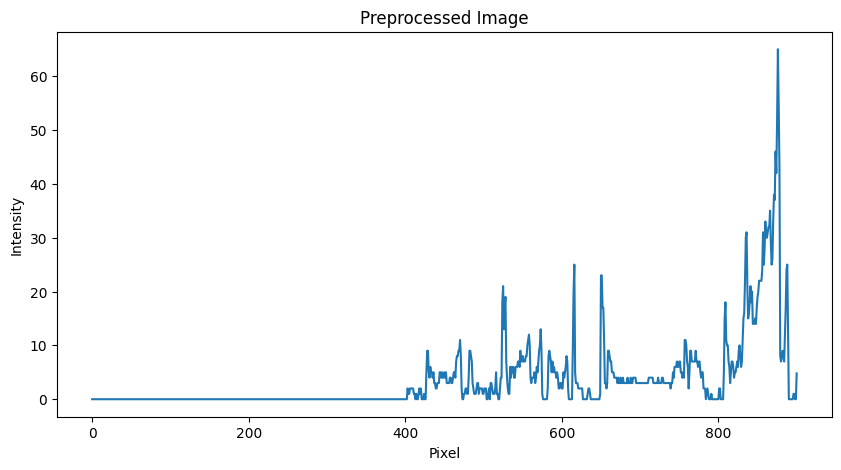

In [ ]:
# Preprocess the image
preprocessed_img = prepare(img)

# Visualize the preprocessed image
plt.figure(figsize=(10, 5))
plt.title('Preprocessed Image')
plt.plot(preprocessed_img)
plt.xlabel('Pixel')
plt.ylabel('Intensity')
plt.show()

In [ ]:
print(len(preprocessed_img))

901


In [ ]:
training_data = []
for filename in os.listdir(training_folder):
    img = cv2.imread(os.path.join(training_folder, filename), 0)
    if img is not None:
        data = np.array(prepare(img))
        data = np.reshape(data, (901, 1))
        result = [[0], [1]] if "genuine" in filename else [[1], [0]]
        result = np.array(result)
        result = np.reshape(result, (2, 1))
        #print(result)
        training_data.append([data, result])

test_data = []
for filename in os.listdir(test_folder):
    img = cv2.imread(os.path.join(test_folder, filename), 0)
    if img is not None:
            data = np.array(prepare(img))
            data = np.reshape(data, (901, 1))
            result = 1 if "genuine" in filename else 0
            test_data.append([data, result])

In [ ]:
current_dir = "/content/drive/My Drive/dataset/"
author = '021'
training_folder = os.path.join(current_dir, 'training/', author)
test_folder = os.path.join(current_dir, 'test/', author)

print(training_folder)
print(test_folder)

for filename in os.listdir(training_folder):
    img = cv2.imread(os.path.join(training_folder, filename), 0)
    if img is not None:
        data = np.array(prepare(img))
        data = np.reshape(data, (901, 1))
        result = [[0], [1]] if "genuine" in filename else [[1], [0]]
        result = np.array(result)
        result = np.reshape(result, (2, 1))
        #print(result)
        training_data.append([data, result])


for filename in os.listdir(test_folder):
    img = cv2.imread(os.path.join(test_folder, filename), 0)
    if img is not None:
            data = np.array(prepare(img))
            data = np.reshape(data, (901, 1))
            result = 1 if "genuine" in filename else 0
            test_data.append([data, result])

/content/drive/My Drive/dataset/training/021
/content/drive/My Drive/dataset/test/021


In [ ]:
current_dir = "/content/drive/My Drive/dataset/"
author = '029'
test_folder = os.path.join(current_dir, 'test/', author)


for filename in os.listdir(test_folder):
    img = cv2.imread(os.path.join(test_folder, filename), 0)
    if img is not None:
            data = np.array(prepare(img))
            data = np.reshape(data, (901, 1))
            result = 1 if "genuine" in filename else 0
            test_data.append([data, result])

In [ ]:
print(len(training_data))
print(len(test_data))

45
55


In [ ]:
print(training_data[0][1])

[[1]
 [0]]


In [ ]:
import numpy as np
import random

def relu(z):
    return np.maximum(0, z)

def relu_prime(z):
    return (z > 0).astype(float)

def softmax(z):
    e_z = np.exp(z - np.max(z))
    return e_z / e_z.sum(axis=0)

def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def sigmoid_prime(z):
    sz = sigmoid(z)
    return sz * (1 - sz)

class NeuralNetwork():

    def __init__(self, sizes, lmbda=0.01):
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y,1) for y in sizes[1:]]
        self.weights = [np.random.randn(y,x) for x,y in zip(sizes[:-1],sizes[1:])]
        self.lmbda = lmbda  # Regularization parameter

    def feedforward(self, a):
        for b, w in zip(self.biases[:-1], self.weights[:-1]):
            a = sigmoid(np.dot(w, a) + b)
        a = softmax(np.dot(self.weights[-1], a) + self.biases[-1])  # softmax for last layer
        return a

    def separate_batches(self, training_data, batch_size):
        random.shuffle(training_data)
        n = len(training_data)
        return [training_data[i:i + batch_size] for i in range(0, n, batch_size)]

    def update_batches(self, batches, alpha, n):
        for batch in batches:
            nabla_b = [np.zeros(b.shape) for b in self.biases]
            nabla_w = [np.zeros(w.shape) for w in self.weights]

            m = len(batch)

            for x, y in batch:
                delta_b, delta_w = self.backpropagation(x, y)
                nabla_b = [nb + dnb for nb, dnb in zip(nabla_b, delta_b)]
                nabla_w = [nw + dnw for nw, dnw in zip(nabla_w, delta_w)]

            self.weights = [(1 - alpha * (self.lmbda / n)) * w - (alpha / m) * nw for w, nw in zip(self.weights, nabla_w)]  # L2 regularization
            self.biases = [b - (alpha / m) * nb for b, nb in zip(self.biases, nabla_b)]

    def backpropagation(self, x, y):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]

        activation = x
        activations = [x]
        zs = []
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)

        delta = self.cost_derivative(activations[-1], y) * \
            relu_prime(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())

        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)

    def sgd(self, training_data, epochs, batch_size, alpha, test_data):
        n_test = len(test_data)

        for epoch in range(epochs):
            batches = self.separate_batches(training_data, batch_size)
            self.update_batches(batches, alpha, len(training_data))

            print("Epoch {0}: {1} / {2}".format(epoch, self.evaluate(test_data), n_test))

        num_correct = self.evaluate(test_data)
        accuracy = num_correct / n_test
        print("Accuracy at end of training: {0}".format(accuracy))

    def evaluate(self, test_data):
        test_results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in test_data]
        return sum(int(x == y) for (x, y) in test_results)

    def cost_derivative(self, output_activations, y):
        return output_activations - y

In [ ]:
net = NeuralNetwork([901, 500, 500, 2])
net.sgd(training_data, 100, 50, 0.001, test_data)

<ipython-input-240-297e6d5b5efe>:15: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-z))


Epoch 0: 31 / 55
Epoch 1: 31 / 55
Epoch 2: 31 / 55
Epoch 3: 32 / 55
Epoch 4: 33 / 55
Epoch 5: 33 / 55
Epoch 6: 33 / 55
Epoch 7: 33 / 55
Epoch 8: 33 / 55
Epoch 9: 33 / 55
Epoch 10: 33 / 55
Epoch 11: 33 / 55
Epoch 12: 33 / 55
Epoch 13: 33 / 55
Epoch 14: 32 / 55
Epoch 15: 32 / 55
Epoch 16: 32 / 55
Epoch 17: 33 / 55
Epoch 18: 33 / 55
Epoch 19: 33 / 55
Epoch 20: 33 / 55
Epoch 21: 33 / 55
Epoch 22: 33 / 55
Epoch 23: 33 / 55
Epoch 24: 33 / 55
Epoch 25: 33 / 55
Epoch 26: 34 / 55
Epoch 27: 34 / 55
Epoch 28: 34 / 55
Epoch 29: 34 / 55
Epoch 30: 34 / 55
Epoch 31: 34 / 55
Epoch 32: 34 / 55
Epoch 33: 34 / 55
Epoch 34: 37 / 55
Epoch 35: 37 / 55
Epoch 36: 37 / 55
Epoch 37: 37 / 55
Epoch 38: 37 / 55
Epoch 39: 37 / 55
Epoch 40: 37 / 55
Epoch 41: 37 / 55
Epoch 42: 37 / 55
Epoch 43: 37 / 55
Epoch 44: 37 / 55
Epoch 45: 36 / 55
Epoch 46: 36 / 55
Epoch 47: 36 / 55
Epoch 48: 36 / 55
Epoch 49: 36 / 55
Epoch 50: 36 / 55
Epoch 51: 39 / 55
Epoch 52: 39 / 55
Epoch 53: 39 / 55
Epoch 54: 39 / 55
Epoch 55: 39 / 55
Ep

<ipython-input-240-297e6d5b5efe>:15: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-z))


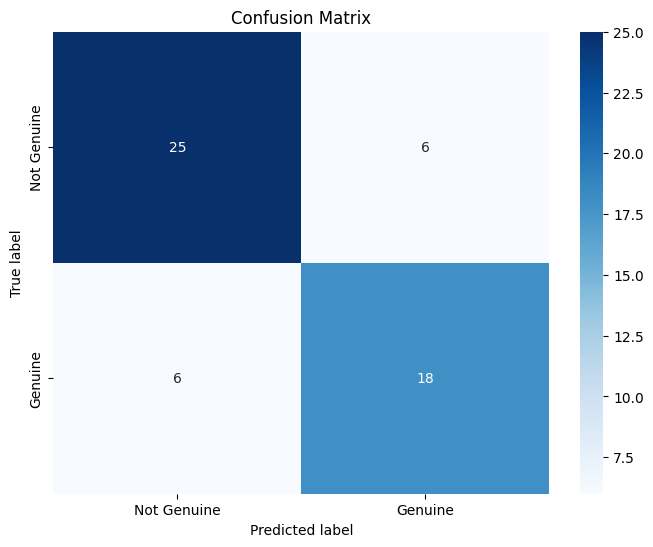

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming test_data is a list of tuples (x, y) where x is the input data and y is the corresponding label

# Calculate predictions using the evaluate function
test_results = [(np.argmax(net.feedforward(x)), y) for (x, y) in test_data]
predictions, labels = zip(*test_results)

# Compute confusion matrix
conf_matrix = confusion_matrix(labels, predictions)

# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Genuine', 'Genuine'], yticklabels=['Not Genuine', 'Genuine'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


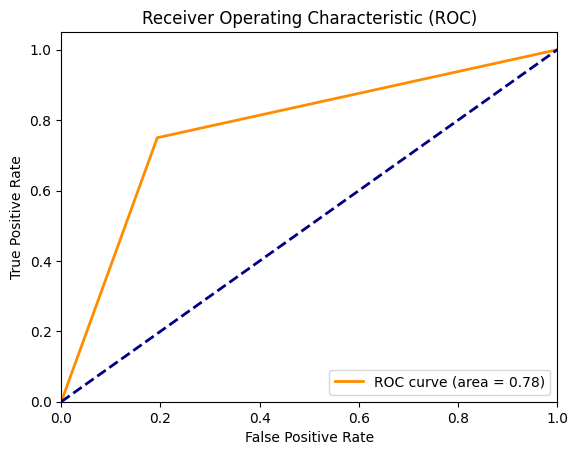

In [ ]:
# Compute ROC Curve
fpr, tpr, _ = roc_curve(labels, predictions)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

SVM

In [ ]:
# Flatten the input data and concatenate it with the labels
flattened_data = np.concatenate([x.flatten() for x, _ in training_data] + [y.flatten() for _, y in training_data])

# Print unique values
unique_values = np.unique(flattened_data)
print("Unique values in training data:", unique_values)


Unique values in training data: [ 0.          1.          1.36941176  1.37866667  1.3802521   1.41241685
  1.43049327  1.44671202  1.44759825  1.46846847  1.5         1.56124722
  1.57337884  1.59953704  1.61341853  1.61564626  1.68321513  1.72542373
  1.72805139  1.73368146  1.73604061  1.79051383  1.82037534  1.87850467
  1.91290323  1.97938144  2.          2.0075188   2.06037736  2.15209125
  2.16071429  2.16115702  2.19172932  2.33196721  2.40909091  2.6300578
  2.65079365  2.74786325  2.79365079  3.          3.04608295  3.13173653
  3.39574468  3.61386139  3.7611336   3.91810345  3.92703863  4.
  4.3626943   4.79768786  5.          6.          7.          8.
  9.         10.         11.         12.         13.         14.
 15.         16.         17.         18.         19.         20.
 21.         22.         23.         24.         25.         26.
 27.         28.         29.         30.         31.         32.
 33.         34.         35.         36.         37.         38.
 39

In [ ]:
def preprocess_image_svm(input):
    # Resize the image to 40x10
    resized_img = cv2.resize(input, (40, 10), interpolation=cv2.INTER_AREA)

    # Flatten the resized image
    flatten_img = resized_img.flatten()

    # Resize to 400x100
    resized_large = cv2.resize(input, (400, 100), interpolation=cv2.INTER_AREA)
    columns = np.sum(resized_large, axis=0)  # Sum of all columns
    lines = np.sum(resized_large, axis=1)  # Sum of all lines

    h, w = input.shape
    aspect = w / h

    return [*flatten_img, *columns, *lines, aspect]


In [ ]:
current_dir = "/content/drive/My Drive/dataset/"
author = '024'
training_folder = os.path.join(current_dir, 'training/', author)
test_folder = os.path.join(current_dir, 'test/', author)

In [ ]:
training_data = []
for filename in os.listdir(training_folder):
    img = cv2.imread(os.path.join(training_folder, filename), 0)
    if img is not None:
        data = np.array(preprocess_image_svm(img))
        data = np.reshape(data, (901, 1))
        result = 1 if "genuine" in filename else 0
        result = np.array(result)
        #result = np.reshape(result, (2, 1))
        #print(result)
        training_data.append((data, result))

test_data = []
for filename in os.listdir(test_folder):
    img = cv2.imread(os.path.join(test_folder, filename), 0)
    if img is not None:
            data = np.array(preprocess_image_svm(img))
            data = np.reshape(data, (901, 1))
            result = 1 if "genuine" in filename else 0
            test_data.append((data, result))

In [ ]:
current_dir = "/content/drive/My Drive/dataset/"
author = '021'
training_folder = os.path.join(current_dir, 'training/', author)
test_folder = os.path.join(current_dir, 'test/', author)

for filename in os.listdir(training_folder):
    img = cv2.imread(os.path.join(training_folder, filename), 0)
    if img is not None:
        data = np.array(preprocess_image_svm(img))
        data = np.reshape(data, (901, 1))
        result = 1 if "genuine" in filename else 0
        result = np.array(result)
        #result = np.reshape(result, (2, 1))
        #print(result)
        training_data.append((data, result))


for filename in os.listdir(test_folder):
    img = cv2.imread(os.path.join(test_folder, filename), 0)
    if img is not None:
            data = np.array(preprocess_image_svm(img))
            data = np.reshape(data, (901, 1))
            result = 1 if "genuine" in filename else 0
            test_data.append((data, result))

In [ ]:
current_dir = "/content/drive/My Drive/dataset/"
author = '029'

test_folder = os.path.join(current_dir, 'test/', author)

for filename in os.listdir(test_folder):
    img = cv2.imread(os.path.join(test_folder, filename), 0)
    if img is not None:
            data = np.array(preprocess_image_svm(img))
            data = np.reshape(data, (901, 1))
            result = 1 if "genuine" in filename else 0
            test_data.append((data, result))

In [ ]:
print(len(training_data))
print(training_data[1][0])

21
[[2.49000000e+02]
 [2.50000000e+02]
 [2.50000000e+02]
 [2.50000000e+02]
 [2.50000000e+02]
 [2.50000000e+02]
 [2.50000000e+02]
 [2.50000000e+02]
 [2.50000000e+02]
 [2.50000000e+02]
 [2.50000000e+02]
 [2.50000000e+02]
 [2.50000000e+02]
 [2.50000000e+02]
 [2.50000000e+02]
 [2.50000000e+02]
 [2.50000000e+02]
 [2.11000000e+02]
 [1.67000000e+02]
 [2.49000000e+02]
 [2.50000000e+02]
 [2.50000000e+02]
 [2.50000000e+02]
 [2.50000000e+02]
 [2.50000000e+02]
 [2.50000000e+02]
 [2.50000000e+02]
 [2.50000000e+02]
 [2.50000000e+02]
 [2.50000000e+02]
 [2.50000000e+02]
 [2.50000000e+02]
 [2.50000000e+02]
 [2.50000000e+02]
 [2.50000000e+02]
 [2.50000000e+02]
 [2.50000000e+02]
 [2.50000000e+02]
 [2.50000000e+02]
 [2.50000000e+02]
 [2.49000000e+02]
 [2.50000000e+02]
 [2.50000000e+02]
 [2.50000000e+02]
 [2.50000000e+02]
 [2.50000000e+02]
 [2.50000000e+02]
 [2.50000000e+02]
 [2.50000000e+02]
 [2.50000000e+02]
 [2.50000000e+02]
 [2.50000000e+02]
 [2.50000000e+02]
 [2.50000000e+02]
 [2.50000000e+02]
 [2.500

In [ ]:
from sklearn import svm

In [ ]:
x_train = [data[0] for data in training_data]
y_train = [data[1] for data in training_data]
print(np.asarray(x_train).shape, np.asarray(y_train).shape)

(45, 901, 1) (45,)


In [ ]:
x_test = [data[0] for data in test_data]
y_test = [data[1] for data in test_data]
print(np.asarray(x_test).shape, np.asarray(y_test).shape)

(55, 901, 1) (55,)


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
class SVMModel:
    def __init__(self):
        self.model = None
        self.tested = False
        self.train_accuracy = []
        self.test_accuracy = []
        self.confusion_matrices = []
        self.f1_scores = []
        self.y_preds = []

    def train(self, x_train, y_train, X_test, y_test, epochs=10):
        #print(x_train.shape)
        for epoch in range(epochs):
            self.model = svm.SVC(kernel='linear')

            self.model.fit(x_train, y_train)

            train_accuracy = self.evaluate(x_train, y_train)[0]
            test_accuracy, confusion_matrix, f1_score, y_pred = self.evaluate(X_test, y_test)

            self.train_accuracy.append(train_accuracy)
            self.test_accuracy.append(test_accuracy)
            self.confusion_matrices.append(confusion_matrix)
            self.f1_scores.append(f1_score)
            self.y_preds.append(y_pred)

            print("Epoch {}: Train Accuracy: {:.4f}, Test Accuracy: {:.4f}, F1 Score: {:.4f}".format(epoch, train_accuracy, test_accuracy, f1_score))

        self.tested = True

    def evaluate(self, X, y):
        y_pred = self.model.predict(X)
        accuracy = accuracy_score(y, y_pred)
        confusion_mat = confusion_matrix(y, y_pred)
        f1 = f1_score(y, y_pred, average='weighted')
        return accuracy, confusion_mat, f1, y_pred

    def plot_accuracy(self):
        plt.plot(range(len(self.train_accuracy)), self.train_accuracy, label='Train Accuracy')
        plt.plot(range(len(self.test_accuracy)), self.test_accuracy, label='Test Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Accuracy Over Time')
        plt.legend()
        plt.show()

    def plot_f1_score(self):
        plt.plot(range(len(self.f1_scores)), self.f1_scores)
        plt.xlabel('Epoch')
        plt.ylabel('F1 Score')
        plt.title('F1 Score Over Time')
        plt.show()

    def plot_decision_boundary(self,X, y):
        print(X.shape)
        assert X.shape[1] == 2, "Plotting is only supported for 2D feature space."

        # Create a meshgrid to evaluate the score function over the given extent
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
        print(xx.shape,yy.shape)
        Z = self.model.decision_function(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        plt.contourf(xx, yy, Z, alpha=0.8)
        plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.title('Decision Boundary and Contour Lines')
        plt.show()

    def plot_confusion_matrix(self, cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        plt.figure(figsize=(8, 6))
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()

        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.

        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                plt.text(j, i, format(cm[i, j], fmt),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.show()


    def plot_roc_curve(self, y_test, y_pred_proba):
      fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
      roc_auc = auc(fpr, tpr)
      plt.figure()
      plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
      plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
      plt.xlim([0.0, 1.0])
      plt.ylim([0.0, 1.05])
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')
      plt.title('Receiver Operating Characteristic')
      plt.legend(loc="lower right")
      plt.show()

    def plot_learning_curve(self, estimator, X, y, title="Learning Curves"):
      train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=5)
      train_scores_mean = np.mean(train_scores, axis=1)
      test_scores_mean = np.mean(test_scores, axis=1)
      plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
      plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
      plt.xlabel("Training examples")
      plt.ylabel("Score")
      plt.legend(loc="best")
      plt.grid()
      plt.title(title)
      plt.show()


(55, 901) (55,)
Epoch 0: Train Accuracy: 1.0000, Test Accuracy: 0.7091, F1 Score: 0.6995
Epoch 1: Train Accuracy: 1.0000, Test Accuracy: 0.7091, F1 Score: 0.6995
Epoch 2: Train Accuracy: 1.0000, Test Accuracy: 0.7091, F1 Score: 0.6995
Epoch 3: Train Accuracy: 1.0000, Test Accuracy: 0.7091, F1 Score: 0.6995
Epoch 4: Train Accuracy: 1.0000, Test Accuracy: 0.7091, F1 Score: 0.6995
Epoch 5: Train Accuracy: 1.0000, Test Accuracy: 0.7091, F1 Score: 0.6995
Epoch 6: Train Accuracy: 1.0000, Test Accuracy: 0.7091, F1 Score: 0.6995
Epoch 7: Train Accuracy: 1.0000, Test Accuracy: 0.7091, F1 Score: 0.6995
Epoch 8: Train Accuracy: 1.0000, Test Accuracy: 0.7091, F1 Score: 0.6995
Epoch 9: Train Accuracy: 1.0000, Test Accuracy: 0.7091, F1 Score: 0.6995


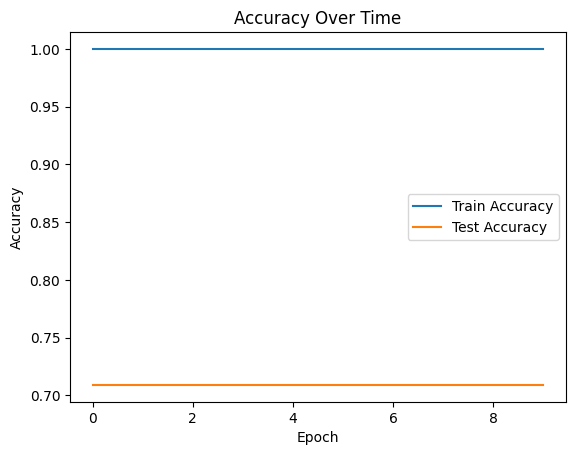

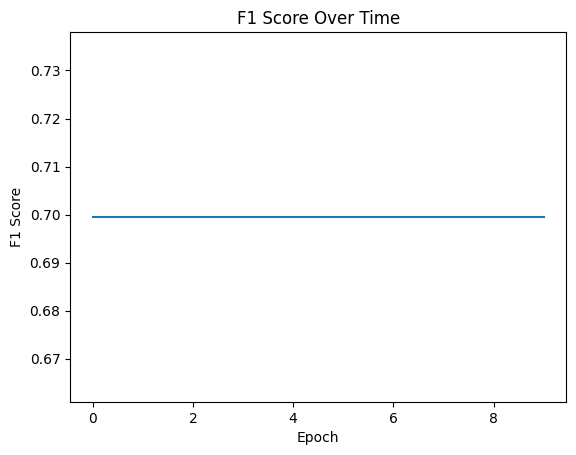

In [ ]:
# Example usage
svm_model = SVMModel()
x_train = np.array(x_train).reshape(len(x_train), -1)
y_train = np.array(y_train).reshape(-1)
x_test = np.array(x_test).reshape(len(x_test), -1)
y_test = np.array(y_test).reshape(-1)

print(x_test.shape,y_test.shape)
#print(x_train.shape,y_train.shape)
svm_model.train(x_train, y_train, x_test, y_test, epochs=10)

# Plot accuracy and F1 score over time
svm_model.plot_accuracy()
svm_model.plot_f1_score()

In [ ]:
print(x_train.ndim)

2


In [ ]:
print(x_train.shape)
print(y_train.shape)

(21, 901)
(21,)


In [ ]:
print(np.asarray(svm_model.y_preds))

[[0 1 1 1 1 1 0 0 1 1 0 1 1 0 0 0 1 1 1 1 0 1 1 1]
 [0 1 1 1 1 1 0 0 1 1 0 1 1 0 0 0 1 1 1 1 0 1 1 1]
 [0 1 1 1 1 1 0 0 1 1 0 1 1 0 0 0 1 1 1 1 0 1 1 1]
 [0 1 1 1 1 1 0 0 1 1 0 1 1 0 0 0 1 1 1 1 0 1 1 1]
 [0 1 1 1 1 1 0 0 1 1 0 1 1 0 0 0 1 1 1 1 0 1 1 1]
 [0 1 1 1 1 1 0 0 1 1 0 1 1 0 0 0 1 1 1 1 0 1 1 1]
 [0 1 1 1 1 1 0 0 1 1 0 1 1 0 0 0 1 1 1 1 0 1 1 1]
 [0 1 1 1 1 1 0 0 1 1 0 1 1 0 0 0 1 1 1 1 0 1 1 1]
 [0 1 1 1 1 1 0 0 1 1 0 1 1 0 0 0 1 1 1 1 0 1 1 1]
 [0 1 1 1 1 1 0 0 1 1 0 1 1 0 0 0 1 1 1 1 0 1 1 1]]


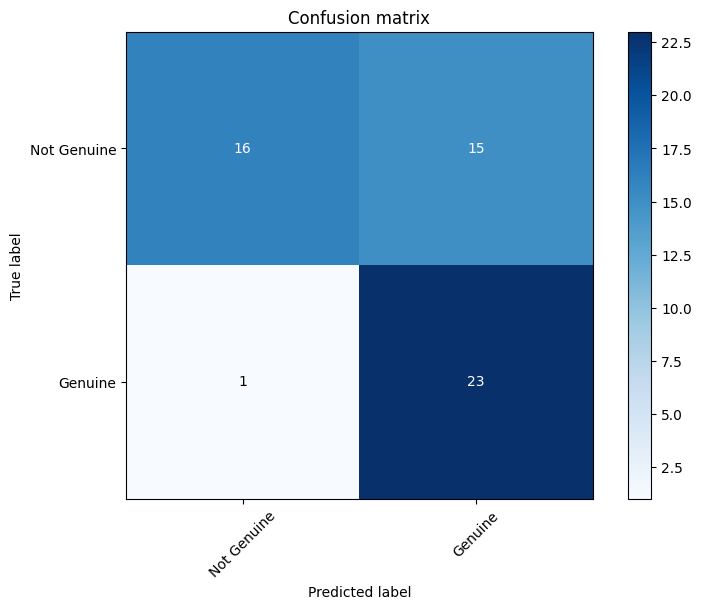

In [ ]:
import seaborn as sns

# Usage
cm = confusion_matrix(y_test, svm_model.y_preds[9])
svm_model.plot_confusion_matrix(cm, classes=['Not Genuine', 'Genuine'])

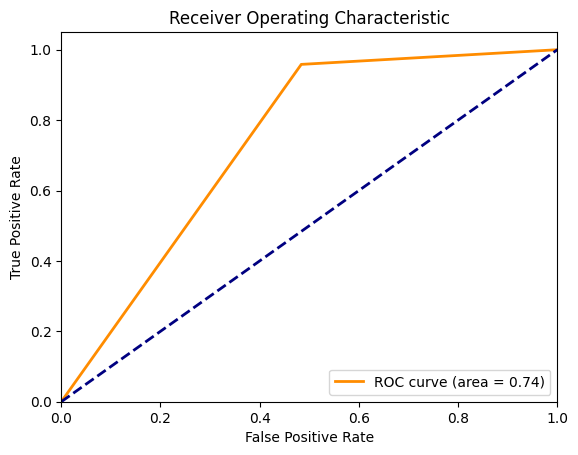

In [ ]:
from sklearn.metrics import roc_curve, auc

# Usage
svm_model.plot_roc_curve(y_test, svm_model.y_preds[9])

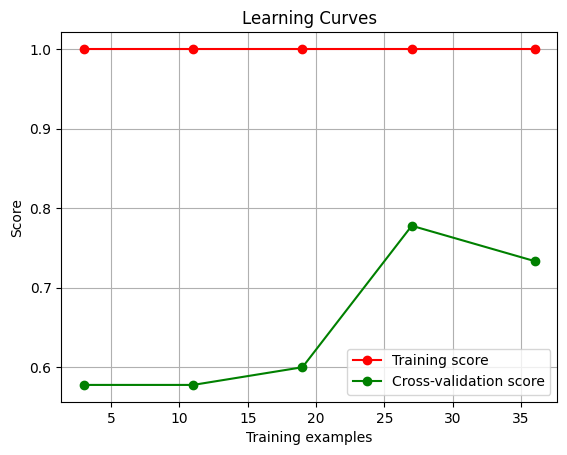

In [ ]:
from sklearn.model_selection import learning_curve

# Usage
svm_model.plot_learning_curve(svm_model.model, x_train, y_train)

In [ ]:
import os
from skimage import io, transform
import numpy as np

data = []
labels = []

root_dir = "/content/drive/My Drive/dataset/training"  # replace with your root directory

# Loop over the directories (024, 025, 029)
for dir_name in os.listdir(root_dir):
    dir_path = os.path.join(root_dir, dir_name)

    # Loop over the files in each directory
    for file_name in os.listdir(dir_path):
        if file_name.endswith(".png"):
            file_path = os.path.join(dir_path, file_name)
            img = io.imread(file_path, as_gray=True)
            img = transform.resize(img, (128, 128))
            data.append(img)

            # Assign labels based on the file name
            if "genuine" in file_name:
                labels.append(1)
            elif "forged" in file_name:
                labels.append(0)


In [ ]:
root_dir = "/content/drive/My Drive/dataset/test"

# Loop over the directories (024, 025, 029)
for dir_name in os.listdir(root_dir):
    dir_path = os.path.join(root_dir, dir_name)

    # Loop over the files in each directory
    for file_name in os.listdir(dir_path):
        if file_name.endswith(".png"):
            file_path = os.path.join(dir_path, file_name)
            img = io.imread(file_path, as_gray=True)
            img = transform.resize(img, (128, 128))
            data.append(img)

            # Assign labels based on the file name
            if "genuine" in file_name:
                labels.append(1)
            elif "forged" in file_name:
                labels.append(0)

In [ ]:
data = np.array(data)
data = data.reshape((data.shape[0], 128, 128, 1))
labels = np.array(labels)

In [ ]:
print(data.shape,labels)

(100, 128, 128, 1) [0 0 1 1 0 1 0 1 0 0 1 0 0 0 0 0 1 1 1 0 1 0 1 0 0 0 0 1 0 1 0 1 1 1 1 1 0
 1 0 0 0 1 1 0 1 0 1 0 0 1 0 1 1 1 1 1 0 0 1 0 0 1 1 1 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 1 1 0 1 0 0 1 1 0 0 0 0 0 0 1 1 1 1 0 1 1 1]


In [ ]:
import re
from skimage import io, transform
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.7),
    Dense(1, activation='sigmoid')
])

In [ ]:
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_test, y_test))

Epoch 1/20
3/3 [==============================] - 4s 908ms/step - loss: 1.5471 - accuracy: 0.5625 - val_loss: 1.1014 - val_accuracy: 0.6500
Epoch 2/20
3/3 [==============================] - 2s 547ms/step - loss: 1.5561 - accuracy: 0.4875 - val_loss: 0.8321 - val_accuracy: 0.3500
Epoch 3/20
3/3 [==============================] - 2s 531ms/step - loss: 1.0276 - accuracy: 0.4500 - val_loss: 0.6718 - val_accuracy: 0.6500
Epoch 4/20
3/3 [==============================] - 2s 910ms/step - loss: 0.7056 - accuracy: 0.5125 - val_loss: 0.6703 - val_accuracy: 0.6500
Epoch 5/20
3/3 [==============================] - 3s 879ms/step - loss: 0.7141 - accuracy: 0.5000 - val_loss: 0.6663 - val_accuracy: 0.6500
Epoch 6/20
3/3 [==============================] - 2s 530ms/step - loss: 0.6873 - accuracy: 0.5500 - val_loss: 0.6540 - val_accuracy: 0.6500
Epoch 7/20
3/3 [==============================] - 2s 536ms/step - loss: 0.6796 - accuracy: 0.5375 - val_loss: 0.6294 - val_accuracy: 0.6500
Epoch 8/20
3/3 [====

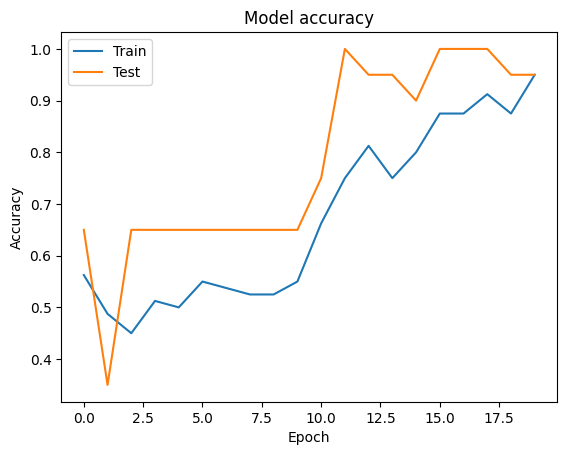

In [ ]:
# plot learning curve
def plot_learning_curve(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

plot_learning_curve(history)

In [ ]:
def evaluate_model_accuracy(model, X_test, y_test):
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print("Test accuracy:", test_accuracy)

evaluate_model_accuracy(model, X_test, y_test)

1/1 [==============================] - 0s 122ms/step - loss: 0.0991 - accuracy: 0.9500
Test accuracy: 0.949999988079071


1/1 [==============================] - 0s 205ms/step


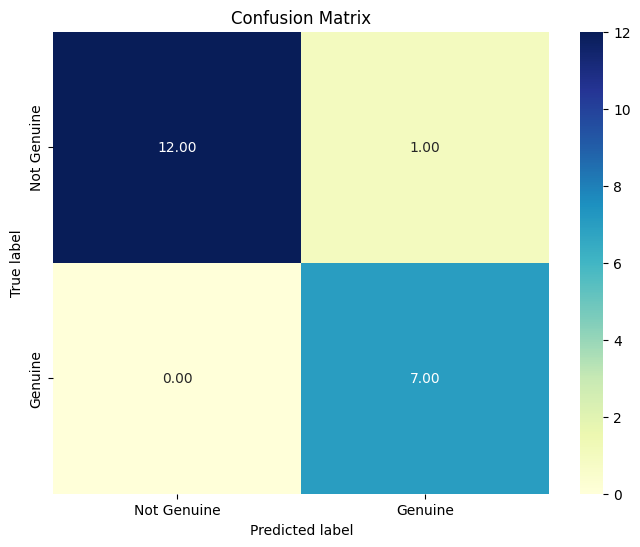

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Make predictions on the test data
y_pred_prob = model.predict(X_test)
y_pred = np.round(y_pred_prob).astype(int)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt=".2f", cmap="YlGnBu", xticklabels=['Not Genuine', 'Genuine'], yticklabels=['Not Genuine', 'Genuine'], cbar=True)

plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

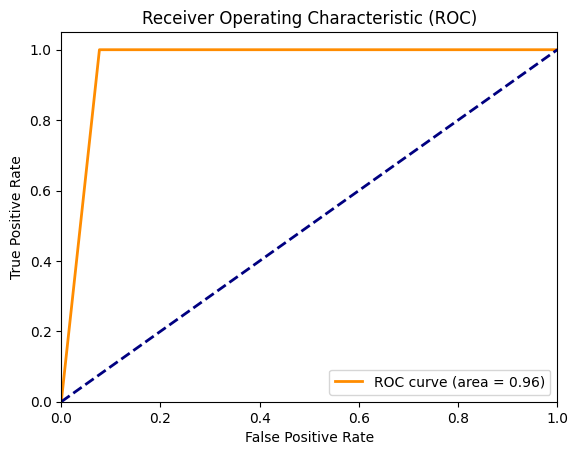

In [ ]:
# Compute ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()